In [21]:
import trackpy as tp
import numpy as np
import scipy as sp
import pims as pm
import pandas as pd
import matplotlib as mtp
import matplotlib.pyplot as plt
import h5py as h5
import os
import copy as cp
import ipywidgets as wd
import cv2 as cv

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, HTML
from pims import pipeline
from matplotlib import animation, rc

%matplotlib inline

@pipeline
def as_gray(frame):
    red = frame[:, :, 0]
    green = frame[:, :, 1]
    blue = frame[:, :, 2]
    return 0.2125 * red + 0.7154 * green + 0.0721 * blue

First load movie reference

In [2]:
VideoPath = "C:\\Users\\aortiza\\Desktop\\VIDEO.avi"
frames = pm.Video(VideoPath)
frame_no=int((frames.duration)*frames.frame_rate-1)

# Get Parameters

## Contrast Enhancement Parameters

In [9]:
BrSlider = wd.FloatSlider(value=0.30,min=0,max=1,step=0.05,continuous_update=False)
CnSlider = wd.FloatSlider(value=0.2,min=0,max=2,step=0.05,continuous_update=False)

@interact(
    i = wd.IntSlider(value=0,min=0,max=frame_no,step=1,continuous_update=False),
    Br = BrSlider,
    Cn = CnSlider)
def Curve(Br,Cn,i):
    plt.figure(figsize=(10,10))
    
    ax1 = plt.subplot2grid((7,1),(0,0))
    ax3 = plt.subplot2grid((7,1),(1,0),rowspan=6)
    
    hist = cv.calcHist([frames[i]],[0],None,[256],[0,256])

    Vout, Vin = DynamicRangeCurve(Br,Cn)
    Image = DynamicRangeProcess(as_gray(frames[i]),Br,Cn)
    
    ax1.plot(Vin,Vout);
    ax1.set_xlim([0,255])
    ax1.set_ylim([0,255])
    
    ax2 = ax1.twinx()
    ax2.bar(np.arange(0,256),hist[:,0]);
    ax3.imshow(Image,cmap='gray');

interactive(children=(FloatSlider(value=0.3, continuous_update=False, description='Br', max=1.0, step=0.05), FloatSlider(value=0.2, continuous_update=False, description='Cn', max=2.0, step=0.05), IntSlider(value=0, continuous_update=False, description='i', max=144), Output()), _dom_classes=('widget-interact',))

In [10]:
@pipeline
def EnhanceContrast(frame):
    return DynamicRangeProcess(frame,BrSlider.value,CnSlider.value)

## Tracking Parameters: Bright Spots

In [11]:
SizeSlider = wd.IntSlider(value=7,min=1,max=51,step=2,continuous_update=False)
ThreSlider = wd.IntSlider(value=25,min=0,max=255,step=1,continuous_update=False)
MinMSlider = wd.IntSlider(value=100,min=0,max=10000,step=25,continuous_update=False)
MaxSSlider = wd.FloatSlider(value=1.8,min=0,max=5,step=0.2,continuous_update=False)
PeakSlider = wd.IntSlider(value=80,min=0,max=100,step=1,continuous_update=False)
w = wd.IntSlider(
    value=130,
    min=0,
    max=frame_no,
    step=1,
    continuous_update=False)

f = tp.locate(EnhanceContrast(as_gray(frames[0])), 11, invert=True)
@interact(
    i = w,
    Sz = SizeSlider,
    Tr = ThreSlider,
    Mm = MinMSlider,
    Pk = PeakSlider,
    Ms = MaxSSlider)
def SingleFrameFind(i,Sz,Tr,Mm,Pk,Ms):
    f = tp.locate(EnhanceContrast(as_gray(frames[i])), Sz, 
                  invert=False,characterize=True,
                  threshold=Tr,minmass=Mm,percentile=Pk,
                  maxsize=Ms)
    
    fig, ax = plt.subplots(1,1,figsize=(12,12))
    ax.imshow(EnhanceContrast(as_gray(frames[i])),cmap='gray');
    ax.plot(f.x,f.y,'o',fillstyle='none')

interactive(children=(IntSlider(value=130, continuous_update=False, description='i', max=144), IntSlider(value=7, continuous_update=False, description='Sz', max=51, min=1, step=2), IntSlider(value=25, continuous_update=False, description='Tr', max=255), IntSlider(value=100, continuous_update=False, description='Mm', max=10000, step=25), IntSlider(value=80, continuous_update=False, description='Pk'), FloatSlider(value=1.8, continuous_update=False, description='Ms', max=5.0, step=0.2), Output()), _dom_classes=('widget-interact',))

In [13]:
BrightSpots = tp.batch(EnhanceContrast(as_gray(frames[:])), 7, 
                  invert=False,characterize=True,
                  threshold=25,percentile=80,
                  maxsize=1.8)

Frame 144: 915 features


In [14]:
HTML(AnimatePoints(BrightSpots,frames).to_html5_video())

## Tracking Parameters: Central Spot

In [35]:
SizeSlider = wd.IntSlider(value=33,min=1,max=51,step=2,continuous_update=False)
ThreSlider = wd.IntSlider(value=25,min=0,max=255,step=1,continuous_update=False)
MinMSlider = wd.IntSlider(value=100,min=0,max=100000,step=25,continuous_update=False)
MaxSSlider = wd.FloatSlider(value=1.8,min=0,max=5,step=0.2,continuous_update=False)
PeakSlider = wd.IntSlider(value=80,min=0,max=100,step=1,continuous_update=False)
w = wd.IntSlider(
    value=130,
    min=0,
    max=frame_no,
    step=1,
    continuous_update=False)

f = tp.locate(as_gray(frames[0]), 11, invert=True)
@interact(
    i = w,
    Sz = SizeSlider,
    Tr = ThreSlider,
    Mm = MinMSlider,
    Pk = PeakSlider,
    Ms = MaxSSlider)
def SingleFrameFind(i,Sz,Tr,Mm,Pk,Ms):
    f = tp.locate(EnhanceContrast(as_gray(frames[i])), Sz, 
                  invert=True,characterize=True,
                  threshold=Tr,minmass=Mm,percentile=Pk)
    
    fig, ax = plt.subplots(1,1,figsize=(12,12))
    ax.imshow(tp.bandpass(255-EnhanceContrast(as_gray(frames[i])),lshort=1,llong=Sz),cmap='gray');
    #ax.imshow(255-EnhanceContrast(as_gray(frames[i])),cmap='gray');
    ax.plot(f.x,f.y,'o',fillstyle='none')

interactive(children=(IntSlider(value=130, continuous_update=False, description='i', max=144), IntSlider(value=33, continuous_update=False, description='Sz', max=51, min=1, step=2), IntSlider(value=25, continuous_update=False, description='Tr', max=255), IntSlider(value=100, continuous_update=False, description='Mm', max=100000, step=25), IntSlider(value=80, continuous_update=False, description='Pk'), FloatSlider(value=1.8, continuous_update=False, description='Ms', max=5.0, step=0.2), Output()), _dom_classes=('widget-interact',))

In [43]:
CentralSpot = tp.batch(EnhanceContrast(as_gray(frames[:])), 33, 
                  invert=True,characterize=False,
                  threshold=25,minmass=44000,percentile=80,topn=3)

Frame 144: 3 features


In [45]:
HTML(AnimatePoints(CentralSpot,frames).to_html5_video())

# Particle Linking

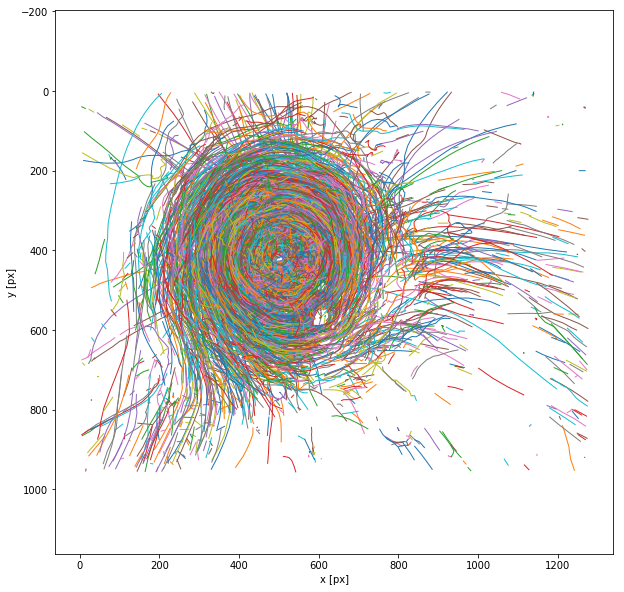

In [20]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.axis('equal')
tp.plot_traj(Trayectories);

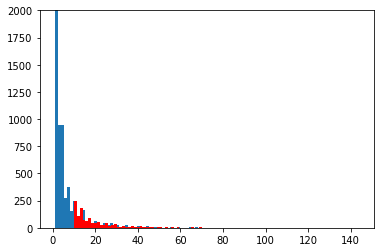

In [23]:
T_filtered = cp.deepcopy(Trayectories)
plt.hist(Trayectories.groupby('particle').size(),bins=100)
T_filtered = tp.filter_stubs(T_filtered, 10)
plt.hist(T_filtered.groupby('particle').size(),bins=100,color='red')
plt.ylim(0,2000);

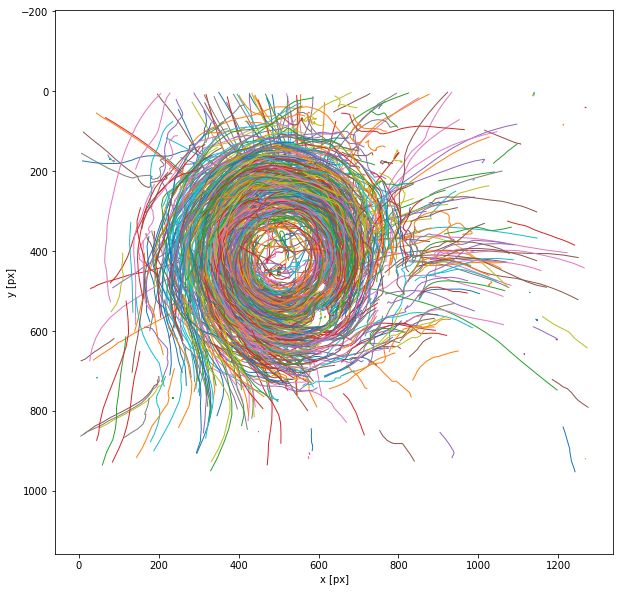

In [68]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.axis('equal')
tp.plot_traj(T_filtered);

In [65]:
pred = tpred.NearestVelocityPredict()

Center = pred.link_df(CentralSpot, 10)

Frame 144: 3 trajectories present


In [66]:
center_prt = Center.groupby('particle').count().idxmax().frame

Center = Center[Center.particle==center_prt]

In [74]:
Center.index = Center.frame

# Save Center and Trayectories

In [77]:
ScaleAndSaveTrayectory(T_filtered,"//MAGNETIC/Antonio/RotatingMill/Mill_10Hz.dat")
ScaleAndSaveTrayectory(Center,"//MAGNETIC/Antonio/RotatingMill/Mill_10Hz_Center.dat")

# Support Functions

In [5]:
def DynamicRangeCurve(Br,Cn):
    """ This function returns a mapping to be applied to an image to enhance contrast and brightness """
    Vin = np.arange(0,255)    
    if Cn==0:
        Cn=1e-10
    Vout = (Vin-Br*255)/Cn+127.5
    Vout[Vout>=255]=255
    Vout[Vout<0]=0
    
    return Vout, Vin

def DynamicRangeProcess(Image,Br,Cn):
    """ This function takes a Brightness and Contrast parameter and applies it to a figure"""
    Image = (Image-Br*255)/Cn+127.5
    Image[Image>255]=255
    Image[Image<0]=0
    return Image

In [6]:
def AnimatePoints(P,Frames):
    frame_no = P.frame.max()

    fig, ax = plt.subplots(1,1,figsize=(10,10))
    Points = ax.plot(0,0,'o',fillstyle="none")
    Image = ax.imshow(Frames[0])
    plt.close()

    def init():
        Points[0].set_data([],[])
        Image.set_data(Frames[0])
        return (Points)

    def animate(i):
        fr_ind=(P.frame==i)
        Points[0].set_data(P[fr_ind].x,P[fr_ind].y)
        Image.set_data(Frames[i])
        return (Points)

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                       frames=np.arange(0,frame_no,1), interval=200, blit=False)
    return anim


In [67]:
def ScaleAndSaveTrayectory(T,Name):
    T_output = T.filter(['x','y','particle'])

    fps = 1
    px_size = 25/76

    T_output['t'] = T_output.index/fps
    T_output['x'] = T_output.x*px_size
    T_output['y'] = T_output.y*px_size

    for i,p in enumerate(T_output.particle.unique()):
        T_output.loc[T_output.particle==p,'particle']=i
        
    T_output.to_csv(Name,
                        sep='\t',header=True,index=True, columns = ["t","x","y","particle"],float_format="%8.11g")